In [1]:
import pandas as pd
import numpy as np
import urllib.request
import os
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
data_url = "https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv"

filename = "cars_data.csv"

if not os.path.exists(filename):
    urllib.request.urlretrieve(data_url, filename)

df = pd.read_csv(filename)

In [3]:
def df_clean(df):
    df.columns = df.columns.str.lower().str.replace(" ", "_")
    
    string_columns = df.dtypes[df.dtypes == "object"].index

    for col in string_columns:
        df[col] = df[col].str.lower().str.replace(" ", "_")

    return df

In [5]:
np.random.seed(2)

m = len(df)

m_val = int(0.2 * m)
m_test = int(0.2 * m)
m_train = m - m_val - m_test

idx = np.arange(m)
np.random.shuffle(idx)

df_cleaned = df_clean(df)
df_shuffled = df_cleaned.iloc[idx]

df_train = df_shuffled.iloc[:m_train].copy()
df_val = df_shuffled.iloc[m_train:m_train+m_val].copy()
df_test = df_shuffled.iloc[m_train+m_val:].copy()

y_train_orig = df_train.msrp.values
y_val_orig = df_val.msrp.values
y_test_orig = df_test.msrp.values

y_train = np.log1p(df_train.msrp.values)
y_val = np.log1p(df_val.msrp.values)
y_test = np.log1p(df_test.msrp.values)

del df_train["msrp"]
del df_val["msrp"]
del df_test["msrp"]

In [33]:
def train_lin_reg(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y)
    
    return w[0], w[1:] # bias, weights

In [7]:
BASE_FEATURES = ["engine_hp", "engine_cylinders", "highway_mpg", "city_mpg", "popularity"]

In [34]:
def prepare_X(df) -> np.ndarray:
    df_num = df[BASE_FEATURES]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [35]:
model_a = dict()

In [36]:
X_train = prepare_X(df_train)
w_0, w = train_lin_reg(X_train, y_train)

y_hat = w_0 + X_train.dot(w)

model_a["bias"] = w_0
model_a["weights"] = w
model_a["predictions"] = y_hat
model_a["features"] = BASE_FEATURES

Text(0, 0.5, 'Frequency')

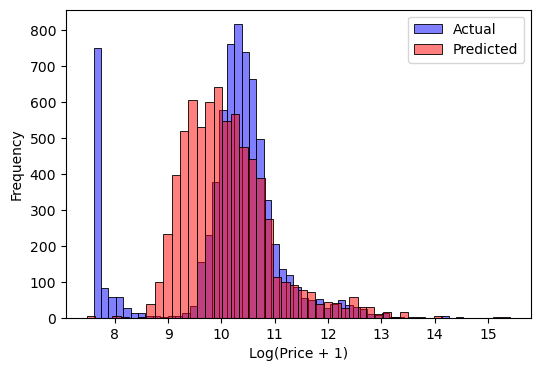

In [14]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, color="blue", alpha=0.5, bins=50)
sns.histplot(y_hat, color="red", alpha=0.5, bins=50)

plt.legend(["Actual", "Predicted"])
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")

In [22]:
def rmse(y, y_pred):
    error = y - y_pred
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [37]:
model_a["rmse"] = rmse(y_train, y_hat)
model_a["rmse"].round(4)

np.float64(0.7554)

In [38]:
X_val = prepare_X(df_val)
y_hat = w_0 + X_val.dot(w)

model_a["val_predictions"] = y_hat
model_a["val_rmse"] = rmse(y_val, y_hat)
model_a["val_rmse"].round(4)

np.float64(0.7617)

In [30]:
def prepare_X_b(df) -> np.ndarray:
    df = df.copy()
    features = BASE_FEATURES.copy()

    df["age"] = 2017 - df.year
    features.append("age")

    df_num = df[features]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

In [39]:
model_b = dict()

X_train = prepare_X_b(df_train)
w_0, w = train_lin_reg(X_train, y_train)

y_hat = w_0 + X_train.dot(w)

model_b["bias"] = w_0
model_b["weights"] = w
model_b["predictions"] = y_hat
model_b["features"] = BASE_FEATURES + ["age"]
model_b["rmse"] = rmse(y_train, y_hat)

X_val = prepare_X_b(df_val)
y_hat = w_0 + X_val.dot(w)

model_b["val_predictions"] = y_hat
model_b["val_rmse"] = rmse(y_val, y_hat)

print("Model A RMSE: ", model_a["rmse"].round(4))
print("Model B RMSE: ", model_b["rmse"].round(4))

print("Model A Validation RMSE: ", model_a["val_rmse"].round(4))
print("Model B Validation RMSE: ", model_b["val_rmse"].round(4))


Model A RMSE:  0.7554
Model B RMSE:  0.5175
Model A Validation RMSE:  0.7617
Model B Validation RMSE:  0.5172


Text(0, 0.5, 'Frequency')

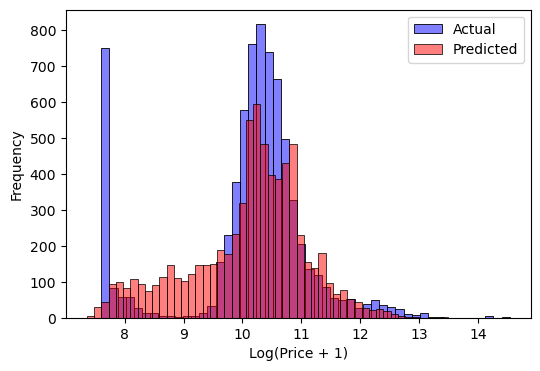

In [40]:
plt.figure(figsize=(6, 4))

sns.histplot(y_train, color="blue", alpha=0.5, bins=50)
sns.histplot(model_b["predictions"], color="red", alpha=0.5, bins=50)

plt.legend(["Actual", "Predicted"])
plt.xlabel("Log(Price + 1)")
plt.ylabel("Frequency")